### Vanden Bussche, Fromment 1995

Tabelle 8 Kp(RWGS)
467K. Berechnet 1.54e+00	Artikel 1.69e+00
489K. Berechnet 1.84e+00	Artikel 2.04e+00
522K. Berechnet 2.34e+00	Artikel 2.64e+00
511K. Berechnet 2.16e+00	Artikel 2.43e+00
360K. Berechnet 5.42e-01	Artikel 5.69e-01
381K. Berechnet 6.86e-01	Artikel 7.24e-01
404K. Berechnet 8.70e-01	Artikel 9.28e-01


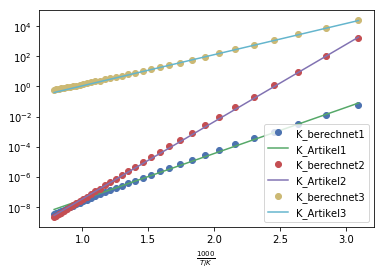

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tc_lib import *
%matplotlib inline
plt.style.use('seaborn-deep')

# Stoechiometrische Koeffizienten
nuij = np.zeros([len(namen), 3])
# Hydrierung von CO2
nuij[[
    namen.index('CO2'),
    namen.index('H2'),
    namen.index('CH3OH'),
    namen.index('H2O'),
    namen.index('CO'),
],0] = np.array([-1, -3, +1, +1, 0], dtype=float)
# Hydrierung von CO
nuij[[
    namen.index('CO2'),
    namen.index('H2'),
    namen.index('CH3OH'),
    namen.index('H2O'),
    namen.index('CO'),
],1] = np.array([0, -2, +1, 0, -1], dtype=float)
# RWGS Rückwassergasshiftreaktion
nuij[[
    namen.index('CO2'),
    namen.index('H2'),
    namen.index('CH3OH'),
    namen.index('H2O'),
    namen.index('CO'),
],2] = np.array([+1, +1, 0, -1, -1], dtype=float)

# T-abhängige Parameter, dem Artikel nach
def k_gg(t):
    # Geschwindigkeitskonstanten der 3 Reaktionen
    k_1 = 10**(3066/t-10.592)
    k_2 = 10**(5139/t-12.621)
    k_3 = 10**(2073/t-2.029)
    # Angepasste Parameter des kinetischen Modells
    # A(i) exp(B(i)/RT)
    a = np.array([
        0.499, 6.62e-11, 3453.38, 1.07, 1.22e-10
    ], dtype=float)
    b = np.array([
        17197, 124119, 0, 36696, -94765
    ], dtype=float)
    k_h2 = a[0]**2 * np.exp(2 * b[0]/(r * t))
    k_h2o = a[1] * np.exp(b[1]/(r * t))
    k_h2o_d_k_8_k_9_k_h2 = a[2] * np.exp(b[2]/(r * t))
    k5a_k_2_k_3_k_4_k_h2 = a[3] * np.exp(b[3]/(r * t))
    k1_strich = a[4] * np.exp(b[4]/(r * t))
    return np.array([
        k_1, k_2, k_3,
        k_h2, k_h2o, k_h2o_d_k_8_k_9_k_h2,
        k5a_k_2_k_3_k_4_k_h2, k1_strich
    ])

# Gleichgewichtskonstanten bei T, berechnet
def k_t(t, nuij):
    h_t = h(t)
    g_t = g(t, h_t)
    k_t = k(t, g_t, nuij)
    return k_t

t = np.linspace(50, 1000, 35) + 273.15
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(nuij.shape[1]):
    ax.plot(1000/t, 
            [k_t(temp, nuij[:,i]) for temp in t],
            'o', label='K_berechnet'+str(i+1))
    ax.plot(1000/t, k_gg(t)[i], 
            '-', label='K_Artikel'+str(i+1))
ax.set_yscale('log')
ax.set_xlabel(r'$\frac{1000}{T/K}$')
ax.legend()

print('Tabelle 8 Kp(RWGS)')
for t in np.array([467, 489, 522, 511, 360, 381, 404]):
    print(
        str(t) + 'K' + '. Berechnet ' +
        '{:.2e}'.format(1/k_t(t+273.15, nuij)[2]*10) + 
        '\t' + 'Artikel ' +
        '{:.2e}'.format(1/k_gg(t+273.15)[2]*10)
    )
    
def r_i(t, p_i):
    p_co2 = p[namen.index('CO2')]
    p_h2 = p[namen.index('H2')]
    p_ch3oh = p[namen.index('CH3OH')]
    p_h2o = p[namen.index('H2O')]
    [k_1, k_2, k_3, 
    k_h2, k_h2o, k_h2o_d_k_8_k_9_k_h2, 
    k5a_k_2_k_3_k_4_k_h2, k1_strich] = k_gg(t)
    r_meoh = k5a_k_2_k_3_k_4_k_h2 * p_co2 * p_h2 * (
        1 - 1/k_1 * p_h2o * p_ch3oh / (
            p_h2**3 * p_co2
        )
    ) / (
        1 + k_h2o_d_k_8_k_9_k_h2 * ph2o / p_h2 + 
        np.sqrt(k_h2 * p_h2) + k_h20 * p_h2o
    )
    r_rwgs = k1_strich * p_co2 * (
        1 - k_3 * p_h2o * p_co / (p_co2 * p_h2) /(
            1 + k_h2o_d_k_8_k_9_k_h2 * p_h2o / p_h2 +
            np.sqrt(k_h2 * p_h2) + k_h2o * p_h2o
        )
    )
    return np.array([r_meoh, r_rwgs])

#### Umformung auf Aspen-Form

In [160]:
print('1.65*np.exp(-(-94765)/8.3145/501.57)/1e10=' + 
      '{:g}'.format(1.65*np.exp(-(-94765)/8.3145/501.57)/1e10))
a = np.array([
        0.499, 6.62e-11, 3453.38, 1.07, 1.22e10
    ], dtype=float)
b = np.array([
    17197, 124119, 0, 36696, -94765
], dtype=float)
print('')
print('k5a_k_2_k_3_k_4_k_h2:')
print('A_Asp=ln(A/1000)=' + '{:g}'.format(np.log(a[3]/1000.)))
print('B_Asp=B/R=' + '{:g}'.format(b[3]/8.3145)+'K')
print('k5a_k_2_k_3_k_4_k_h2 / k_1:')
print('A_Asp=ln(A/1000)-C ln(10)=' + 
      '{:g}'.format(np.log(a[3]/1000.)-(-10.592*np.log(10))))
print('B_Asp=B/R-D ln(10)=' + 
      '{:g}'.format(b[3]/8.3145 - 3066*np.log(10))+'K')
print('')
print('k1_strich:')
print('A_Asp=ln(A/1000)=' + '{:g}'.format(np.log(a[4]/1000.)))
print('B_Asp=B/R=' + '{:g}'.format(b[4]/8.3145)+'K')
print('k1_strich * k_3:')
print('A_Asp=ln(A/1000)+C ln(10)=' + 
      '{:g}'.format(np.log(a[4]/1000.)+(-2.029*np.log(10))))
print('B_Asp=B/R+D ln(10)=' + 
      '{:g}'.format(b[4]/8.3145 + 2073*np.log(10))+'K')
print('')
print('k_h2o_d_k_8_k_9_k_h2:')
print('A_Asp=ln(A)=' + '{:g}'.format(np.log(a[2])))
print('B_Asp=B/R=' + '{:g}'.format(b[2]/8.3145)+'K')
print('')
print('k_h2^(1/2):')
print('A_Asp=ln(A)=' + '{:g}'.format(np.log(a[0])))
print('B_Asp=B/R=' + '{:g}'.format(b[0]/8.3145)+'K')
print('')
print('k_h2o:')
print('A_Asp=ln(A)=' + '{:g}'.format(np.log(a[1])))
print('B_Asp=B/R=' + '{:g}'.format(b[1]/8.3145)+'K')

1.65*np.exp(-(-94765)/8.3145/501.57)/1e10=1.2198

k5a_k_2_k_3_k_4_k_h2:
A_Asp=ln(A/1000)=-6.8401
B_Asp=B/R=4413.49K
k5a_k_2_k_3_k_4_k_h2 / k_1:
A_Asp=ln(A/1000)-C ln(10)=17.5489
B_Asp=B/R-D ln(10)=-2646.23K

k1_strich:
A_Asp=ln(A/1000)=16.3169
B_Asp=B/R=-11397.6K
k1_strich * k_3:
A_Asp=ln(A/1000)+C ln(10)=11.645
B_Asp=B/R+D ln(10)=-6624.3K

k_h2o_d_k_8_k_9_k_h2:
A_Asp=ln(A)=8.14711
B_Asp=B/R=0K

k_h2^(1/2):
A_Asp=ln(A)=-0.695149
B_Asp=B/R=2068.31K

k_h2o:
A_Asp=ln(A)=-23.4383
B_Asp=B/R=14928K


## Umformung auf Hysys-Form
$r[=]\frac{mol}{kg_{Kat}\cdot s} \quad r_{Hysys}[=]\frac{kgmol}{m^3_{Gas} \cdot s}$

$\begin{array}{ccl}
\phi &[=]& \frac{m^3_{Gas}}{m^3_{Kat, Schüttung}}=\frac{m^3_{Gas}}{m^3_{Kat}+m^3_{Gas}}\\
1-\phi &[=]& \frac{m^3_{Kat}}{m^3_{Kat, Schüttung}}=\frac{m^3_{Kat}}{m^3_{Kat}+m^3_{Gas}}\\
\rho_b &[=]& \frac{kg_{Kat}}{m^3_{Kat, Schüttung}}=\frac{kg_{Kat}}{m^3_{Kat}+m^3_{Gas}}\\
\rho_c &[=]& \frac{kg_{Kat}}{m^3_{Kat}}\\
\Rightarrow \rho_b &=&  (1-\phi)\rho_c\\
\Rightarrow r_{Hysys} &=& r\cdot \left( \frac{1-\phi}{\phi}\right)\rho_c
\end{array}$

**Kinetik-Ausdrücke**, aus Van den Bussche-Froment, auf $Cu/ZnO/Al_2O_3$ Katalysator

$p_i$ hier eigentlich: $p_i/p^{\circ}$ , $p^{\circ}=1bar$. Es heißt, $r_{MeOH}$ hat die Einheiten $r_{MeOH}[=]k_{5a}'=k_{5a}c_t^2=\frac{mol}{kg_{Kat}\cdot s}$, und die Reaktionsquotienten haben keine Einheiten.

$r_{MeOH}=\frac{k_{5a}' K_2' K_3 K_4 K_{H_2} p_{CO_2}p_{H_2}\left(1-\frac{1}{K_1^*}\cdot\frac{p_{H_2O}\cdot p_{MeOH}}{p_{H_2}^3\cdot p_{CO_2}}\right)}{\left(1+\left(\frac{K_{H_2O}}{K_8 K_9 K_{H_2}}\right)\frac{p_{H_2O}}{p_{H_2}}+\sqrt{K_{H_2}\cdot p_{H2}}+K_{H_2O}\cdot p_{H_2O}\right)^3}$

$r_{RWGS}=\frac{k_1' p_{CO_2}\left(1-K_3^*\cdot\frac{p_{H_2O}\cdot p_{CO}}{p_{H_2}\cdot p_{CO_2}}\right)}{\left(1+\left(\frac{K_{H_2O}}{K_8 K_9 K_{H_2}}\right)\frac{p_{H_2O}}{p_{H_2}}+\sqrt{K_{H_2}\cdot p_{H2}}+K_{H_2O}\cdot p_{H_2O}\right)}$

Umformung der Geschwindigkeitskonstanten von der Form im Artikel auf die Form 
in Hysys:

$k = A \cdot exp\left(\frac{-E}{R T}\right)*T^\beta$

* $r_{MeOH}$, Vorwärtsreation

im Artikel (Tabelle 1):

$k(i) = A(i) \cdot exp\left(\frac{B(i)}{R T}\right)$

$\begin{align}
k_{5a}' K_2' K_3 K_4 K_{H_2} &=7070,34 \cdot e^{\frac{-36696}{8,3145\cdot501,57}} \frac{mol}{kg_{Kat}\cdot s} \cdot exp\left(\frac{\frac{36,696 J/mol}{8,3145 J/(mol K)}}{ T}\right) \\
& = 1,066\frac{mol}{kg_{Kat}\cdot s} \cdot exp\left(\frac{4413,49K}{ T}\right)
\end{align}$

Da 

$r_{MeOH}[=]k_{5a}'=k_{5a}c_t^2=\frac{mol}{kg_{Kat}\cdot s} \quad \text{ und } \quad r_{Hysys}[=]\frac{kgmol}{m^3_{Gas} \cdot s}$,

$\Rightarrow r_{Hysys, MeOH} = r_{MeOH}\cdot \left( \frac{1-\phi}{\phi}\right)\rho_c \cdot \left(\frac{1 kgmol}{1000 mol}\right)$

Diese Faktoren werden am Preexponentiellen Faktor des Geschwindigkeits-Ausdrucks übernommen. Z. B. bei $\phi=0,285$, $\rho_b=1190\frac{kg_{Kat}}{m^3_{Kat, Schüttung}}=(1-\phi)\rho_c$:

$\begin{align}
k_{Vorwärtsreaktion} &=\\
k_{5a}' K_2' K_3 K_4 K_{H_2} &= 7070,34\cdot e^{\frac{-36696}{8,3145\cdot501,57}}  \frac{mol}{kg_{Kat}\cdot s} \cdot \left( \frac{1-\phi}{\phi}\right)\rho_c \cdot \left(\frac{1 kgmol}{1000 mol}\right)  \cdot exp\left(\frac{4413,49K}{ T}\right)\\
&= 7070,34\cdot e^{\frac{-36696}{8,3145\cdot501,57}}  \frac{mol}{kg_{Kat}\cdot s} \cdot \left( \frac{1190\frac{kg_{Kat}}{m^3_{Kat, Schüttung}}}{0,285\frac{m^3_{Gas}}{m^3_{Kat, Schüttung}} }\right) \cdot \left(\frac{1 kgmol}{1000 mol}\right)  \cdot exp\left(\frac{4413,49K}{ T}\right)\\
&= 7070,34\cdot e^{\frac{-36696}{8,3145\cdot501,57}} \cdot \frac{1190}{0,285\cdot 1000} \frac{kgmol}{m^3_{Gas}\cdot s} \cdot exp\left(\frac{4413,49K}{ T}\right)\\
&= 4,4528 \frac{kgmol}{m^3_{Gas}\cdot s} \cdot exp\left(\frac{36696J/mol}{ R T}\right)\\
\end{align}$

* $r_{MeOH}$, Rückwärtsreaktion

$\begin{align}
k_{Rückwärtsreaktion} &= k_{5a}' K_2' K_3 K_4 K_{H_2} \cdot \frac{1}{K_1*} \\ &= 7070,34\cdot e^{\frac{-36696}{8,3145\cdot501,57}}\cdot \frac{1190}{0,285\cdot 1000} \frac{kgmol}{m^3_{Gas}\cdot s} \cdot exp\left(\frac{36696J/mol}{R T}\right) \cdot 10^\left(-\frac{3066K}{T}+10,592\right)\\
&=7070,34\cdot e^{\frac{-36696}{8,3145\cdot501,57}}\cdot \frac{1190}{0,285\cdot 1000}\cdot 10^{10,592} \frac{kgmol}{m^3_{Gas}\cdot s} \cdot exp\left(\frac{(36696-3066\cdot ln(10)\cdot8,3145)J/mol}{R T}\right)\\
&=1,740321\cdot 10^{11} \frac{kgmol}{m^3_{Gas}\cdot s} \cdot exp\left(\frac{-22002.09J/mol}{R T}\right)\\
\end{align}$

Zusammenfassung der Eingabe von Geschwindigkeitskonstanten aus Tabelle 2 (im Artikel) auf Hysys

$r_{MeOH}$ 

| Geschwindigkeitskonstante | Parameter | Artikel | Hysys-Eingabe | 
| - | - | - | - |
| $k_{5a}' K_2' K_3 K_4 K_{H_2}$ | A(4) |  1,066 $\frac{mol}{kg_{Kat}\cdot s}$ |  4,452761 $\frac{mol}{m^3_{Gas}\cdot s}$ |
| $k_{5a}' K_2' K_3 K_4 K_{H_2}$ | B(4) | 36696 J/mol | -36696 kJ/kgmol |
| $k_{5a}' K_2' K_3 K_4 K_{H_2}\cdot\frac{1}{K_1}$ | |  $1,066\cdot10^{10,592}$$ \frac{mol}{kg_{Kat}\cdot s}$  | $1,740321\cdot10^{11}$$\frac{mol}{m^3_{Gas}\cdot s}$ |
| $k_{5a}' K_2' K_3 K_4 K_{H_2}\cdot\frac{1}{K_1}$ | | $(36696-8,3145\cdot 3066)$ J/mol | -11203,743 kJ/kgmol |

$r_{RWGS}$ 

| Geschwindigkeitskonstante | Parameter | Artikel | Hysys-Eingabe | 
| - | - | - | - |
| $k_1'$ | A(5) |  1,220 $\frac{mol}{kg_{Kat}\cdot s}$ | 5,093209e+10 $\frac{mol}{m^3_{Gas}\cdot s}$ |
| $k_1'$ | B(5) | -94765 J/mol | +94765 kJ/kgmol |
| $k_1'\cdot K_3$ | |  $1,220\cdot 10^{+2,029}$ $mol/kg_{Kat}/s$ | 4,764217e+08 $\frac{kgmol}{m^3_{Gas} \cdot s}$ |
| $k_1'\cdot K_3$ | | $(-94765+8,3145\cdot 2073)$ J/mol | +77529,04 kJ/kgmol |

Adsorptionsterme

| Adsorptionsterm | Parameter | Artikel | Hysys-Eingabe | 
| - | - | - | - |
| $\sqrt{K_{H_2}}$ | A(1) | 30,82 | 30,82 |
| $\sqrt{K_{H_2}}$ | B(1) | 17197 J/mol |  -17197 J/mol |
| $K_{H_2O}$ | A(2) |  558,17 | 558,17 |
| $K_{H_2O}$ | B(2) | 124119 J/mol | -124119 J/mol |
| $\frac{K_{H_2O}}{K_8 K_9 K_{H2}}$ | A(3) |  3453,38 | 3453,38 |
| $\frac{K_{H_2O}}{K_8 K_9 K_{H2}}$ | B(3) | 0 J/mol | 0 J/mol |

In [1]:
import locale
import numpy as np
from IPython.display import Latex
locale.setlocale(locale.LC_ALL, '')

phi = 0.3

table_latex_str = [
    r'\text{Hohlraumvolumen: } \phi=', locale.format('%4.8g',phi),
    r'\\',
    r'\begin{array}{lccccc}',
    '\hline ',
    'Var & A(i) & A(i)_{Hysys} & B(i) & B(i)_{Hysys} & ',
    r'\text{Hysys Param}', r'\\',
    r'\text{Form } K=A(i) \cdot exp\left(\frac{B(i)}{R T}\right) ','&',
    r' \frac{mol}{kg_{Kat}\cdot s} & \frac{mol}{m^3_{Gas}\cdot s}',
    r' & \frac{J}{mol} & \frac{kJ}{kgmol} & ', 
    r'\text{Form } K=A_{Hysys} \cdot exp\left(-\frac{E_{Hysys}}{R T}\right) ', 
    r'\\',
    '\hline ',
    r'\\','r_{MeOH}', r'\\', r'\\',
    "k_{5a}' K_2' K_3 K_4 K_{H_2}", '&',
    locale.format('%4.8g', 7070.34*np.exp(-36696/(8.3145*501.57))), '&',
    locale.format('%4.8g', 7070.34*np.exp(-36696/(8.3145*501.57)
                                           )*1190/phi/1000 ),
    '&',
    locale.format('%4.8g', 36696), '&', 
    locale.format('%4.8g', -36696), '&', 'k_{Vorwärts}',
    r'\\',
    r"k_{5a}' K_2' K_3 K_4 K_{H_2}\cdot \frac{1}{K_1}", '&',
    locale.format('%4.8g', 7070.34*
                  np.exp(-36696/(8.3145*501.57)
                        )*
                  10**10.592
                   ),'&',
    locale.format('%4.8g', 7070.34*
                    np.exp(-36696/(8.3145*501.57)
                          )*
                    1190/phi/1000 *10**10.592
                   ),'&',
    locale.format('%4.8g', (36696-3066*8.3145*np.log(10))),'&',
    locale.format('%4.8g', -(36696-3066*8.3145*np.log(10))),'&', 
    "k'_{Rückwärts}", r'\\'
    r'\\','r_{RWGS}', r'\\', r'\\',
    "k_1'", '&',
    locale.format('%4.8g', 1.65*np.exp(-(-94765)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 1.65*np.exp(-(-94765)/(8.3145*501.57)
                                           )*1190/phi/1000 ), '&',  
    locale.format('%4.8g', -94765), '&',
    locale.format('%4.8g', 94765), '&', 'k_{Vorwärts}',
    r'\\',
    r"k_1' \cdot K_3", '&',
    locale.format('%4.8g', 1.65*np.exp(-(-94765)/(8.3145*501.57))*
                  10**-2.029), '&',
    locale.format('%4.8g', 1.65*np.exp(-(-94765)/(8.3145*501.57))*
                  1190/phi/1000 *10**-2.029 ), '&', 
    locale.format('%4.8g', (-94765+2073*8.3145*np.log(10))),'&',
    locale.format('%4.8g', -(-94765+2073*8.3145*np.log(10))),'&', 
    "k'_{Rückwärts}", r'\\',
    r'\\',r'Adsorptionsterme (\beta)', r'\\', r'\\',
    r'\sqrt{K_{H_2}}', '&', 
    locale.format('%4.8g', 30.82*np.exp(-(17197)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 30.82*np.exp(-(17197)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 17197.), '&',
    locale.format('%4.8g', -17197.), '&', 'K1', r'\\',
    'K_{H_2O}','&', 
    locale.format('%4.8g', 558.17*np.exp(-(124119)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 558.17*np.exp(-(124119)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 124119), '&',
    locale.format('%4.8g', -124119), '&', 'K2', r'\\',
    r'\frac{K_{H_2O}}{K_8 K_9 K_{H2}}','&', 
    locale.format('%4.8g', 3453.38*np.exp(-(0)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 3453.38*np.exp(-(0)/(8.3145*501.57))), '&',
    locale.format('%4.8g', 0), '&',
    locale.format('%4.8g', -0), '&', 'K3', r'\\',
    r'\hline'
    r'\end{array}'
]
Latex('$'+''.join(table_latex_str)+'$')

<IPython.core.display.Latex object>

### WGS auf ICI-Fe3O4-Cr2O3

In [17]:
import locale
import numpy as np
from IPython.display import Latex
locale.setlocale(locale.LC_ALL, '')

epsilon_b = 0.457

table_latex_str = [
    r'\text{Hohlraumvolumen: } \phi=', locale.format('%4.8g',epsilon_b),
    r'\\',
    r'\begin{array}{lccccc}',
    '\hline ',
    'Var & A(i) & A(i)_{Hysys} & B(i) & E(i)_{Hysys} & ',
    r'\text{Hysys Param}', r'\\',
    r'\text{Form } K=A(i) \cdot exp\left(\frac{B(i)}{R T}\right) ','&',
    r' \frac{mol^{0,36} (m^3_{G})^{0,64}}{kg_{Kat}\cdot s}',
    r' & \left(\frac{kgmol}{m^3_{G}}\right)^{0,36} \cdot \frac{1}{s}',
    r' & \frac{J}{mol} & \frac{kJ}{kgmol} & ', 
    r'\text{Form } K=A_{Hysys} \cdot exp\left(-\frac{E_{Hysys}}{R T}\right) ', 
    r'\\',
    '\hline ',
    r'\\','r_{WGS}', r'\\', r'\\',
    "k_m", '&',
    locale.format('%4.8g', np.exp(8.22)), '&',
    locale.format('%4.8g', np.exp(8.22)*(1-epsilon_b)/epsilon_b*1960/1000.**0.36),
    '&',
    locale.format('%4.8g', -8008*8.3145), '&', 
    locale.format('%4.8g', +8008*8.3145), '&', 'k_{Vorwärts}',
    r'\\',
    r"k_m\cdot \frac{1}{K_{eq}}", '&',
    locale.format('%4.8g', np.exp(8.22+4.27)),'&',
    locale.format('%4.8g', np.exp(8.22+4.27)*(1-epsilon_b)/epsilon_b*1960/1000.**0.36),'&',
    locale.format('%4.8g', (-8008-4483)*8.3145),'&',
    locale.format('%4.8g', -(-8008-4483)*8.3145),'&', 
    "k'_{Rückwärts}", r'\\'
    r'\hline'
    r'\end{array}'
]
Latex('$'+''.join(table_latex_str)+'$')

<IPython.core.display.Latex object>

In [18]:
import locale
import numpy as np
from IPython.display import Latex
locale.setlocale(locale.LC_ALL, '')

epsilon_b = 0.457

table_latex_str = [
    r'\text{Hohlraumvolumen: } \phi=', locale.format('%4.8g',epsilon_b),
    r'\\',
    r'\begin{array}{lccccc}',
    '\hline ',
    'Var & A(i) & A(i)_{Hysys} & B(i) & E(i)_{Hysys} & ',
    r'\text{Hysys Param}', r'\\',
    r'\text{Form } K=A(i) \cdot exp\left(\frac{B(i)}{R T}\right) ','&',
    r' \frac{mol^{0,36} (m^3_{G})^{0,64}}{kg_{Kat}\cdot s}',
    r' & \left(\frac{kgmol}{m^3_{G}}\right)^{0,36} \cdot \frac{1}{s}',
    r' & \frac{J}{mol} & \frac{kJ}{kgmol} & ', 
    r'\text{Form } K=A_{Hysys} \cdot exp\left(-\frac{E_{Hysys}}{R T}\right) ', 
    r'\\',
    '\hline ',
    r'\\','r_{WGS}', r'\\', r'\\',
    "k_m", '&',
    locale.format('%4.8g', np.exp(8.22)), '&',
    locale.format('%4.8g', np.exp(8.22)*(1-epsilon_b)/epsilon_b*1960/1000.**0.36),
    '&',
    locale.format('%4.8g', -8008*8.3145), '&', 
    locale.format('%4.8g', +8008*8.3145), '&', 'k_{Vorwärts}',
    r'\\',
    r"k_m\cdot \frac{1}{K_{eq}}", '&',
    locale.format('%4.8g', np.exp(8.22+4.27)),'&',
    locale.format('%4.8g', np.exp(8.22+4.27)*(1-epsilon_b)/epsilon_b*1960/1000.**0.36),'&',
    locale.format('%4.8g', (-8008-4483)*8.3145),'&',
    locale.format('%4.8g', -(-8008-4483)*8.3145),'&', 
    "k'_{Rückwärts}", r'\\'
    r'\hline'
    r'\end{array}'
]
Latex('$'+''.join(table_latex_str)+'$')

<IPython.core.display.Latex object>

### Wedel 1988

In [14]:
k_0_hin = 1.98e+7 # mol/(kg Kat * h * (MPa)^0,58)
ea_hin = 56343 # J/mol
nu_i_hin = np.array([0.18, 0.4, 0]) # CO, H2, CH3OH
k_0_zur = 2.15e+10 # mol/(kg Kat * h * (MPa)^0,13)
ea_zur = 85930 # J/mol
nu_i_zur = np.array([0, 0, 0.13]) # CO, H2, CH3OH
r = 8.314 # J/(mol K) 

def r_j_wedel(k_0, ea, p_i, t, nu_i):
    k_t = k_0 * np.exp(-ea/(r * t))
    return k_t * np.product(np.power(p_i, nu_i))



0.0030628317126543598

In [3]:
nco0 = 2115
nco20 = 235
xi=(nco0-nco20)/2
print(1/10**(2073/(220+273.15)-2.029))
print(xi)
(2115+xi)/10**(2073/(219.9783+273.15)-2.029)+xi-235
#(2115+xi)*0.00631477737+xi-235

0.006689764481429299
940.0


725.4285275642302

### Chem. Eng. Technol. 2011, 34, No. 5, 817–822 

In [ ]:
d = 